# Text Classification 
## importing dataset

In [1]:
#Importing modules
import pandas as pd
 
# Read data into df
df = pd.read_csv(r"C:\Users\anjal\Downloads\archive (10)\Tweets.csv")
# Print head
df.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## plotting priority

<Axes: xlabel='sentiment'>

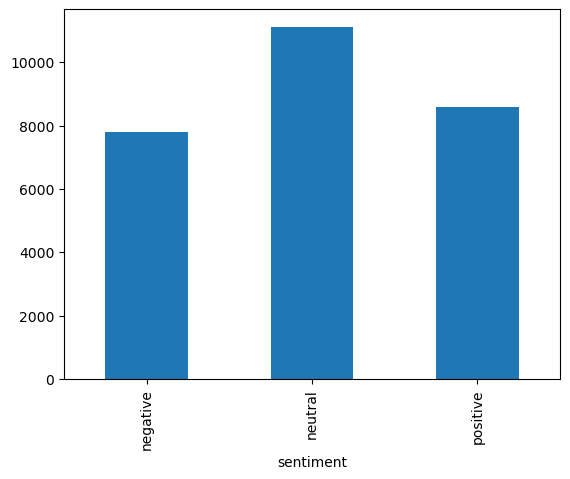

In [2]:
df['sentiment'].value_counts().sort_index().plot(kind='bar')

## Removing odd words

In [3]:
import html
import re
def clean(text):
    # convert html escapes like & to characters.
    text = html.unescape(text) 
    # tags like 
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches  but not #cool
    text = re.sub(r'(?:^|\s)[<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Data cleaning

In [4]:
df = df.dropna()
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2)

,textID,text,selected_text,sentiment
13238,0dffcf014e,thank you You too! I hope this turns out to be...,thank you,positive
10759,dfeabfe450,i honestly hope the theatre gets hit by a mete...,hit by a meteor,negative


## Splitting the Data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  13566
Size of Test Data  3392


## Converting X_trains into the numbers

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Initializing model

In [7]:
from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

## Getting accuracy value

In [8]:
from sklearn.metrics import accuracy_score

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.6258844339622641


## Running dummy classifier

In [9]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.3755896226415094


## Confusing matrix

In [10]:
from sklearn.metrics import confusion_matrix
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[629, 302,  77],
       [292, 718, 264],
       [ 72, 262, 776]], dtype=int64)

## Plotting confusing matrix

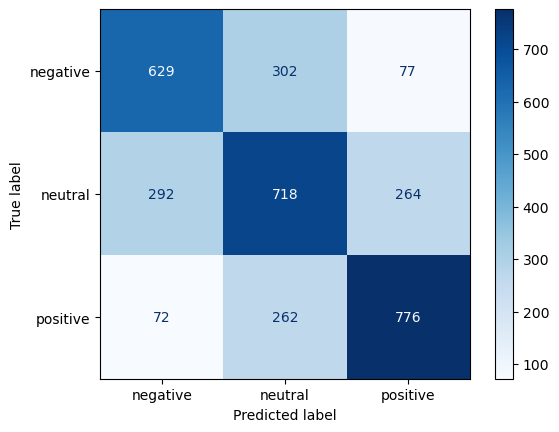

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay as CMD
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, Y_pred)
disp = CMD(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Classification report

In [12]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    negative       0.63      0.62      0.63      1008
     neutral       0.56      0.56      0.56      1274
    positive       0.69      0.70      0.70      1110

    accuracy                           0.63      3392
   macro avg       0.63      0.63      0.63      3392
weighted avg       0.63      0.63      0.63      3392



## Down sampling

In [15]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['sentiment'] == 1].sample(n=0, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['sentiment'] != 1]

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['sentiment'].value_counts()

sentiment
neutral     6371
positive    5547
negative    5040
Name: count, dtype: int64

## Repeating everything

In [16]:
# Loading the balanced dataframe

df = df_balanced[['text', 'sentiment']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  13566
Size of Test Data  3392


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy Score -  0.6258844339622641
              precision    recall  f1-score   support

    negative       0.63      0.62      0.63      1008
     neutral       0.56      0.56      0.56      1274
    positive       0.69      0.70      0.70      1110

    accuracy                           0.63      3392
   macro avg       0.63      0.63      0.63      3392
weighted avg       0.63      0.63      0.63      3392



## Finding best with gridsearchCV

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True
# Loading the dataframe
df = pd.read_csv(r"C:\Users\anjal\Downloads\archive (10)\Tweets.csv")
df = df.dropna()
# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('sentiment', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)
# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])
# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")
if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(X_train, Y_train)
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  2712
Size of Test Data  679
Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.5689466065931378
Accuracy Score -  0.561119293078056
              precision    recall  f1-score   support

    negative       0.59      0.48      0.53       202
     neutral       0.49      0.62      0.55       255
    positive       0.65      0.57      0.61       222

    accuracy                           0.56       679
   macro avg       0.58      0.56      0.56       679
weighted avg       0.57      0.56      0.56       679

